# OH MY WORDLE!
![img](https://gimg2.baidu.com/image_search/src=http%3A%2F%2Fnimg.ws.126.net%2F%3Furl%3Dhttp%253A%252F%252Fdingyue.ws.126.net%252F2022%252F0216%252F60a40469j00r7duyl000fc000ku00arm.jpg%26thumbnail%3D650x2147483647%26quality%3D80%26type%3Djpg&refer=http%3A%2F%2Fnimg.ws.126.net&app=2002&size=f9999,10000&q=a80&n=0&g=0n&fmt=auto?sec=1649986299&t=3367b7b710d3274f136357d754e4be59)

In [61]:
from itertools import cycle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
pd.set_option('display.max_columns', 500)

color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])


In [62]:
df = pd.read_csv('./tweets.csv')

In [63]:
def preprocess(df):
    df.tweet_date = pd.to_datetime(df.tweet_date)
    df['date'] = df.tweet_date.dt.date
    df['n_attempts'] = df.tweet_text.str[11].astype('int')
    df['id'] = df.tweet_text.str[7:10].str[-3:].astype('int')
    df['day'] = df.tweet_date.dt.day_name()
    df.tweet_text = df.tweet_text.str.replace('⬜', '⬛')
    return df

df = preprocess(df)

<AxesSubplot:>

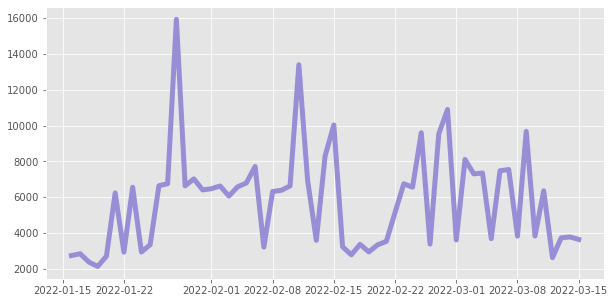

In [64]:
df.date.value_counts().plot(figsize=(10, 5), color=color_pal[2], lw=5)

<AxesSubplot:title={'center':'Number of Attempts'}>

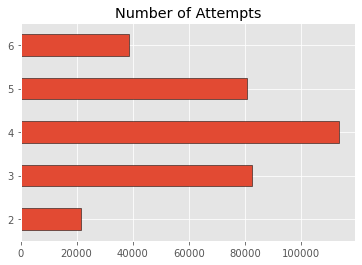

In [65]:
df.n_attempts.value_counts().\
    sort_index().plot(kind='barh',
                      title='Number of Attempts',
                      edgecolor='black')


In [66]:
df.groupby(['date', 'day']).n_attempts.value_counts()\
    .unstack() \
    .style.background_gradient(axis=0)


,n_attempts,2,3,4,5,6
date,day,,,,,
2022-01-16,Sunday,214,863,1027,467,159
2022-01-17,Monday,194,879,998,549,210
2022-01-18,Tuesday,191,782,807,406,179
2022-01-19,Wednesday,53,272,641,683,472
2022-01-20,Thursday,378,1000,818,369,129
2022-01-21,Friday,490,1961,2114,1216,449
2022-01-22,Saturday,225,895,1007,592,202
2022-01-23,Sunday,277,1611,2451,1595,615
2022-01-24,Monday,38,343,927,1039,583


In [67]:
i = 3

# Figure out if it even has a guess
df.tweet_text.str.split('\n') \
    .str[i+1].str.contains('[🟨⬛🟩]+', regex=True) \
    .fillna(False)


0         True
1         True
2         True
3         True
4         True
          ... 
337309    True
337310    True
337311    True
337312    True
337313    True
Name: tweet_text, Length: 337314, dtype: bool

In [68]:
def split_tweet_text(df):
    for i in range(6):
        i += 1

        # Figure out if it even has a guess
        df[f'has_guess{i}'] = \
            df.tweet_text.str.split('\n') \
            .str[i+1].str.contains('^[🟨⬛🟩]+$', regex=True) \
            .fillna(False)

        # Add the text if it's a guess
        df.loc[df[f'has_guess{i}'], f'guess{i}'] = \
            df.tweet_text.str.split('\n').str[i+1].str[:5]

        df.loc[df[f'has_guess{i}'],
               f'guess{i}_incorrect'] = df[f'guess{i}'].str.count('⬛')  # .fillna(0).astype('int')
        df.loc[df[f'has_guess{i}'],
               f'guess{i}_wrong_spot'] = df[f'guess{i}'].str.count('🟨')  # .fillna(0).astype('int')
        df.loc[df[f'has_guess{i}'],
               f'guess{i}_correct'] = df[f'guess{i}'].str.count('🟩')  # .fillna(0).astype('int')

        df.loc[df[f'guess{i}_correct'] == 5, 'final_guess'] = i
    return df


df = split_tweet_text(df)

In [69]:
df['additional_text'] = df.loc[~df.tweet_text.str.split('\n').str[-1].str.contains('🟩')]['tweet_text'].str.split('\n').str[-1]


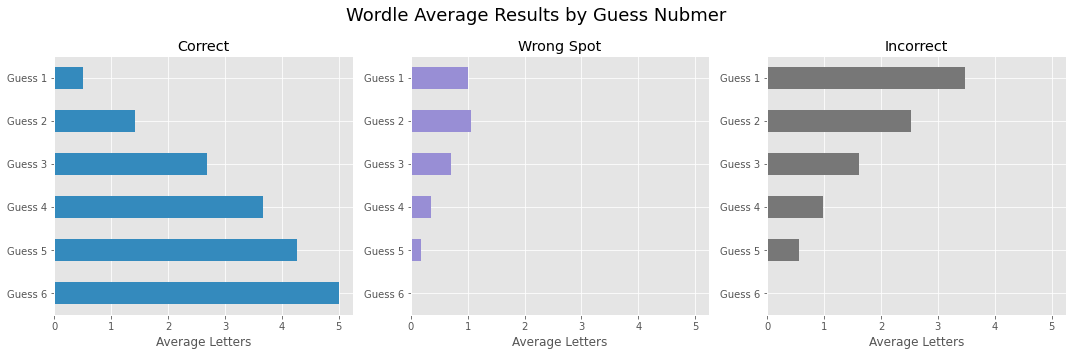

In [70]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True)
for i, x in enumerate(['_correct', '_wrong_spot', '_incorrect']):
    col_subset = [c for c in df.columns if x in c]
    guess_avg = df[col_subset].mean()
    guess_avg.index = [f'Guess {i}' for i in range(1, 7)]

    guess_avg.sort_index(ascending=False) \
        .plot(kind='barh',
              title=f'{x.strip("_").replace("_", " ").title()}',
              ax=axs[i],
              color=color_pal[i+1])
    axs[i].set_xlabel('Average Letters')
fig.suptitle('Wordle Average Results by Guess Nubmer', fontsize=18)
plt.tight_layout()
plt.show()


In [71]:
df.query('guess6_correct == 0').guess6

2709      ⬛⬛⬛⬛⬛
35164     ⬛⬛⬛⬛⬛
45234     ⬛🟨⬛⬛⬛
95626     🟨⬛⬛⬛⬛
96109     ⬛⬛🟨⬛⬛
121092    🟨🟨⬛⬛🟨
153204    🟨⬛⬛⬛⬛
203461    ⬛⬛⬛⬛⬛
228766    ⬛⬛⬛⬛⬛
272761    🟨⬛🟨⬛⬛
284525    ⬛⬛⬛⬛⬛
324369    ⬛⬛⬛⬛⬛
Name: guess6, dtype: object

In [72]:
df = df.set_index('tweet_id')

In [73]:
guess1_split = df.guess1.str.split('', expand=True).drop([0, 6], axis=1)
guess1_split.stack() \
    .reset_index() \
    .rename(columns={'level_1': 'letter_loc',
                     0: 'result'}) \
    .groupby('letter_loc').result.value_counts() \
    .unstack().T \
    .style.background_gradient()

letter_loc,1,2,3,4,5
result,,,,,
⬛,248433,223402,232439,236789,233830
🟨,58431,77461,69952,72230,62401
🟩,30450,36451,34923,28295,41083


In [81]:
guess = 5
guess_split = df[f'guess{guess}'].str. \
    split('', expand=True). \
    drop([0, 6], axis=1)

guess_split = guess_split.stack().reset_index() \
    .rename(columns={'level_1': 'letter_loc', 0: 'result'})

# guess_split_pct = guess_split.groupby('letter_loc').result \
#     .value_counts().unstack().T \
#     .loc['🟩'] / df.index.nunique()
df.guess6.unique()
# df[df.index == 1494679966403166209].guess5

array([nan, '🟩🟩🟩🟩🟩', '⬛⬛⬛⬛⬛', '🟩🟩🟩', '🟩🟩🟩⬛⬛', '⬛🟩🟩🟩🟩', '⬛🟩⬛🟩🟩', '⬛🟨⬛⬛⬛',
       '⬛⬛⬛⬛🟩', '⬛🟩⬛🟩⬛', '🟩🟩⬛🟨⬛', '🟨⬛⬛⬛🟩', '🟨⬛⬛⬛⬛', '⬛⬛🟨⬛⬛', '🟨🟨⬛⬛🟨',
       '🟩⬛⬛⬛⬛', '🟩⬛⬛🟩🟩', '🟨⬛🟨🟩🟩', '🟨🟩🟨🟨⬛', '🟩⬛⬛⬛🟨', '🟩🟩🟩🟩🟨', '⬛🟨🟩🟨🟨',
       '🟨⬛🟨⬛⬛', '⬛🟩⬛⬛⬛', '⬛🟨🟨🟩⬛'], dtype=object)

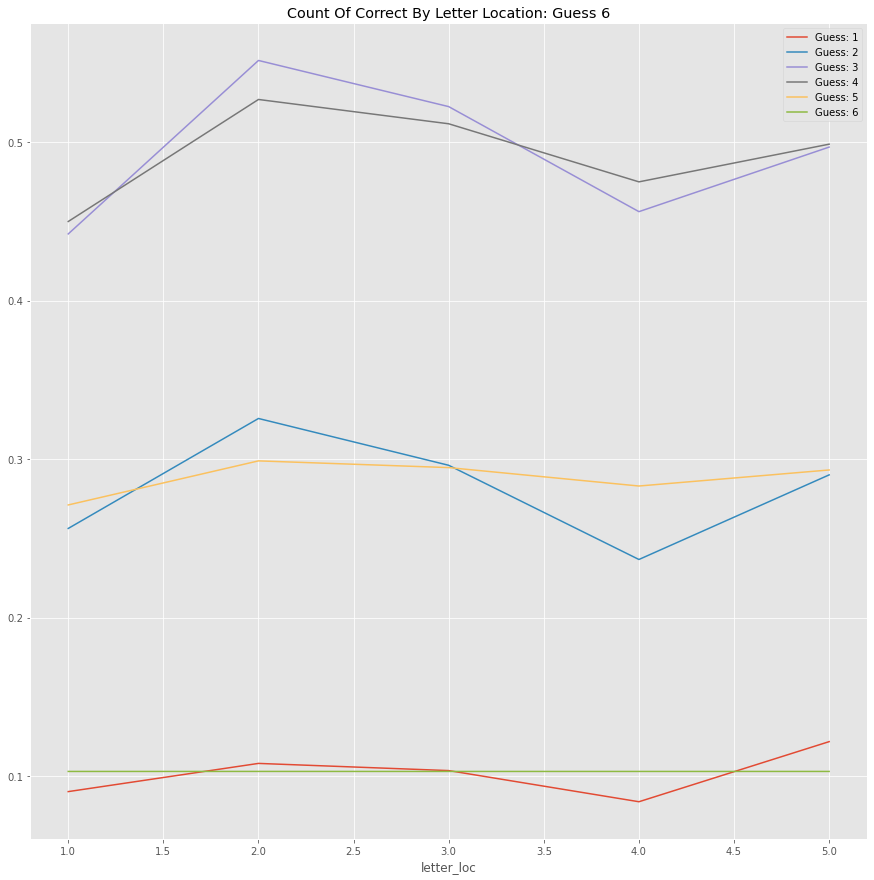

In [83]:
fig, ax = plt.subplots(figsize=(15,15))
for guess in range(6):
    guess += 1
    guess_split = df[f'guess{guess}'].str. \
        split('', expand=True). \
        drop([0, 6], axis=1)

    guess_split = guess_split.stack().reset_index() \
        .rename(columns={'level_1': 'letter_loc', 0: 'result'})

    guess_split_pct = guess_split.groupby('letter_loc').result \
        .value_counts().unstack().T \
        .loc['🟩'] / df.index.nunique()

    guess_split_pct.plot(
        kind='line',
        title=f'count of correct by letter location: Guess {guess}'.title(),
        ax=ax,
        label=f'Guess: {guess}'
    )
plt.legend()
plt.show()
